In [38]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.cluster import FeatureAgglomeration
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import Pipeline
from pykalman import KalmanFilter
import matplotlib.pyplot as plt
import warnings


In [39]:
# Configure matplotlib for Chinese display (optional, based on your OS)
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

# Ignore SettingWithCopyWarning
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# ============================================
# 1. Data Loading & Preparation
# ============================================
df = pd.read_csv('train.csv')

# Define target and ignore columns
target_col = 'market_forward_excess_returns'
ignore_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']

# Store original feature columns (excluding target related ones)
base_feature_cols = [c for c in df.columns if c not in ignore_cols]


In [40]:
# ============================================
# 2. Feature Engineering (Fixing Data Leakage)
# ============================================
print("\n[Step 1] Creating Features (Fixed Look-ahead Bias)...")

# We shift it by 1 to represent returns known at time T (from T-1 to T).
df["realized_return"] = df[target_col].shift(1).fillna(0)

# Base Lagged Features
df["lagged_forward_returns"] = df["forward_returns"].shift(1).fillna(0)
df["lagged_risk_free_rate"] = df["risk_free_rate"].shift(1).fillna(0)
df["lagged_market_forward_excess_returns"] = df["market_forward_excess_returns"].shift(1).fillna(0)

# --- Rolling Statistics (Applied on REALIZED/PAST returns) ---
# We use 'realized_return' instead of 'market_forward_excess_returns'
calculation_series = df['realized_return']
calculation_series


# 1. Rolling Window Statistics
for window in [5, 10, 20]:
    df[f'rolling_mean_{window}'] = calculation_series.rolling(window, min_periods=1).mean()
    df[f'rolling_std_{window}'] = calculation_series.rolling(window, min_periods=1).std().fillna(0)
    df[f'rolling_max_{window}'] = calculation_series.rolling(window, min_periods=1).max()
    df[f'rolling_min_{window}'] = calculation_series.rolling(window, min_periods=1).min()

# 2. Momentum
for period in [2, 5, 10]:
    df[f'momentum_{period}'] = calculation_series.rolling(period, min_periods=1).sum()

# 3. Volatility
df['volatility_5'] = calculation_series.rolling(5, min_periods=1).std().fillna(0)
df['volatility_20'] = calculation_series.rolling(20, min_periods=1).std().fillna(0)

# 4. Trend (Based on past data)
df['trend_5'] = (calculation_series.rolling(5, min_periods=1).mean() > 0).astype(int)
df['trend_10'] = (calculation_series.rolling(10, min_periods=1).mean() > 0).astype(int)

# 5. Lagged Differences (Momentum/Acceleration)
df['return_diff_1'] = calculation_series.diff(1).fillna(0)
df['return_diff_5'] = calculation_series.diff(5).fillna(0)

# Define the full list of features to use
new_features = [
    'lagged_forward_returns', 'lagged_risk_free_rate', 'lagged_market_forward_excess_returns',
    'rolling_mean_5', 'rolling_mean_10', 'rolling_mean_20',
    'rolling_std_5', 'rolling_std_10', 'rolling_std_20',
    'rolling_max_5', 'rolling_max_10', 'rolling_max_20',
    'rolling_min_5', 'rolling_min_10', 'rolling_min_20',
    'momentum_5', 'momentum_10',
    'volatility_5', 'volatility_20',
    'trend_5', 'trend_10',
    'return_diff_1', 'return_diff_5'
]

# Combine base features and new engineering features
feature_cols = base_feature_cols + new_features

# Fill NaNs for the final feature set
X_all = df[feature_cols].ffill().fillna(0)
y_all = df[target_col]

# Time Series Split (80/20)
split = int(len(df) * 0.8)
X_train, X_val = X_all.iloc[:split].copy(), X_all.iloc[split:].copy()
y_train, y_val = y_all.iloc[:split], y_all.iloc[split:]

print(f"Training set size: {len(X_train)}, Validation set size: {len(X_val)}")
print(f"Total features: {len(feature_cols)}")



[Step 1] Creating Features (Fixed Look-ahead Bias)...
Training set size: 7216, Validation set size: 1805
Total features: 117


In [41]:
# ============================================
# 3. Kalman Filter Feature Engineering
# ============================================
print("\n[Step 2] Applying Kalman Filter...")

# Use lagged features for observation to prevent leakage
obs_features = ['lagged_forward_returns', 'lagged_market_forward_excess_returns']

obs_data_train = df[obs_features].iloc[:split].values
obs_data_val = df[obs_features].iloc[split:].values

kf = KalmanFilter(n_dim_obs=len(obs_features), n_dim_state=5)

# Train KF (EM Algorithm) on training data only
print("  Training Kalman Filter...")
kf = kf.em(obs_data_train, n_iter=5)

# Apply Filter
print("  Applying Kalman Filter...")
filtered_train, _ = kf.filter(obs_data_train)
# Use the trained KF to filter validation data (Simulating online usage)
filtered_val, _ = kf.filter(obs_data_val)

# Add KF states as features
for i in range(filtered_train.shape[1]):
    col_name = f'KF_state_{i}'
    X_train[col_name] = filtered_train[:, i]
    X_val[col_name] = filtered_val[:, i]



[Step 2] Applying Kalman Filter...
  Training Kalman Filter...
  Applying Kalman Filter...


In [42]:
# ============================================
# 4. Model Training (Grid Search for Clusters)
# ============================================
print("\n[Step 3] Grid Searching Optimal Cluster Number...")


def calculate_ic(y_true, y_pred):
    """Calculate Information Coefficient (IC)"""
    return np.corrcoef(y_pred, y_true)[0, 1]


def train_and_evaluate(X_tr, y_tr, X_vl, y_vl):
    """Train LGBM and return IC"""
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,  # Lower LR for better generalization
        'num_leaves': 31,
        'max_depth': 6,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.7,
        'bagging_freq': 5,
        'reg_alpha': 0.1,
        'reg_lambda': 0.1,
        'min_child_samples': 20,
        'verbose': -1,
        'seed': 42
    }

    dtrain = lgb.Dataset(X_tr, label=y_tr)
    dval = lgb.Dataset(X_vl, label=y_vl, reference=dtrain)

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dval],
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(0)
        ]
    )

    preds = model.predict(X_vl)
    ic = calculate_ic(y_vl, preds)
    return ic, model


# Test different cluster numbers
cluster_nums = [10, 15, 20, 25, 30]
cluster_results = {}

for n_clusters in cluster_nums:
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('cluster', FeatureAgglomeration(n_clusters=n_clusters))
    ])

    # Fit pipeline on TRAIN only to prevent data leakage in transformation
    X_train_trans = pipe.fit_transform(X_train)
    X_val_trans = pipe.transform(X_val)

    ic, _ = train_and_evaluate(X_train_trans, y_train, X_val_trans, y_val)
    cluster_results[n_clusters] = ic
    print(f"  n_clusters = {n_clusters}, IC = {ic:.4f}")

# Select best cluster number
best_n_clusters = max(cluster_results, key=cluster_results.get)
best_ic = cluster_results[best_n_clusters]
print(f"\n🏆 Best n_clusters: {best_n_clusters}, Best IC: {best_ic:.4f}")



[Step 3] Grid Searching Optimal Cluster Number...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[5]	valid_0's rmse: 0.0111127
  n_clusters = 10, IC = 0.0325
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 0.0111152
  n_clusters = 15, IC = 0.0056
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.0111041
  n_clusters = 20, IC = 0.0433
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[51]	valid_0's rmse: 0.0111112
  n_clusters = 25, IC = 0.0300
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[54]	valid_0's rmse: 0.0111086
  n_clusters = 30, IC = 0.0339

🏆 Best n_clusters: 20, Best IC: 0.0433



[Step 4] Final Training & Evaluation...
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[50]	valid_0's rmse: 0.0111041

📊 Final Results:
  Validation IC: 0.0433
📊 Saved plot: prediction_corrected.png


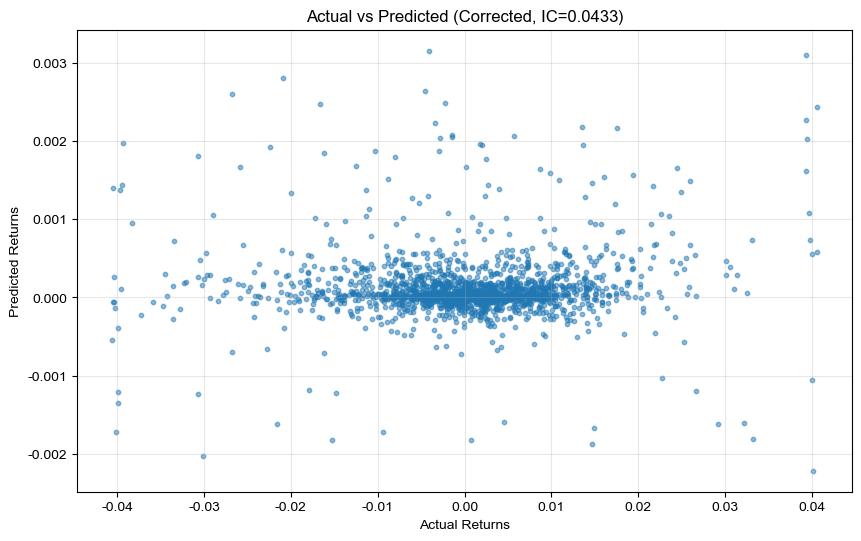

In [43]:
# ============================================
# 5. Final Model & Evaluation
# ============================================
print("\n[Step 4] Final Training & Evaluation...")

optimal_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('cluster', FeatureAgglomeration(n_clusters=best_n_clusters))
])

X_train_final = optimal_pipe.fit_transform(X_train)
X_val_final = optimal_pipe.transform(X_val)

final_ic, final_model = train_and_evaluate(X_train_final, y_train, X_val_final, y_val)

# Predictions for plotting
y_pred = final_model.predict(X_val_final)

print(f"\n📊 Final Results:")
print(f"  Validation IC: {final_ic:.4f}")

# Visualize predictions vs actual (Check for realistic correlation)
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred, alpha=0.5, s=10)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'Actual vs Predicted (Corrected, IC={final_ic:.4f})')
plt.grid(alpha=0.3)
plt.savefig('prediction_corrected.png')
print("📊 Saved plot: prediction_corrected.png")